In [1]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn import metrics 
import scipy.io as spio
from nilearn.input_data import MultiNiftiMasker
from datetime import datetime

from sklearn.metrics import make_scorer,roc_auc_score,f1_score
from sklearn.model_selection import StratifiedKFold

absolute_path_fmri = '/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/arcsin_CSF_pop_tpms_0p9_eroded/'
mask = '/home/kadajji/hydra-work/DELCODE_fMRI_GLMs_parametric/data/M0/glm/temp/GM_mask.nii'




# reading nifti files form the subjs folder
def read_nifti(absolute_path, regex_filter, smooth=None, mask=None):
    mask=mask
    start_time = datetime.now()
    print(start_time)
    regex_filter = str(regex_filter)
    # mask images and get data
    data_folder = str(absolute_path)
    if(mask==None):
        niftimasker = MultiNiftiMasker(smoothing_fwhm=smooth, n_jobs=-2)
    else:
        niftimasker = MultiNiftiMasker(smoothing_fwhm=smooth, n_jobs=-2, mask_img=mask)
    list_path = []
    subjs = []
    i = 0
    for dirs in os.listdir(data_folder):
        for root, dir, files in os.walk(data_folder + dirs):
            for file in files:
                if re.match(regex_filter, file):
                    matter_volume_path = root + '/' + file
                    list_path.append(matter_volume_path)
                    subjs.append(dirs)
                else:
                    pass
        i = i + 1
    print("Reading " + regex_filter + " volume data please wait.........")
    list_path = np.sort(list_path)
    subjs = np.sort(subjs)
    x = niftimasker.fit_transform(list_path)
    x = np.vstack(x)
    subjects_id = pd.DataFrame()
    subjects_id['subjs'] = subjs
    data_matrix = pd.DataFrame(x, dtype='float64')
    end_time = datetime.now()
    time = end_time - start_time
    print("Total time in minutes :", float(time.total_seconds() / 60))
    return data_matrix, subjects_id, niftimasker



# code to split train and test dataset
def train_test_split(dataset, split=0.75):
     train = dataset.sample(frac=split, random_state=120)
     test = dataset.drop(train.index)
     return train, test
 
    

def get_data_mat(mat_url):
     dat = spio.loadmat(mat_url, squeeze_me=True)
     demo = dat['Demo']
     body = dat['Body']
     gen = dat['Gen']
     csf = dat['Csf']
     cog = dat['Cog']
     vol = dat['Vol']
     cog = cog['X'][()]
     csf = csf['X'][()]
     apoe = gen['apoe'][()]['X'][()]
     apoe = pd.DataFrame(apoe)
     apoe4 = ((apoe[0] == 4) + (apoe[1] == 4)) > 0
     delcode_data = pd.DataFrame()
     delcode_data['subjs'] = dat['IDs'][()]
     delcode_data['id'] = demo['IDn'][()]
     delcode_data['age'] = demo['age_bl'][()]
     delcode_data['bmi'] = body['bmi'][()]
     delcode_data['diag'] = demo['diag_bl'][()]
     delcode_data['sex'] = demo['sex'][()]
     delcode_data['apoe'] = apoe4
     delcode_data['edu'] = demo['edu'][()]
     delcode_data['fmem'] = cog[:,21]
     delcode_data['ptau'] = csf[:,4]
     delcode_data['abeta4240'] = csf[:,5]
     return delcode_data



/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
def norm(x):
    return (x-x.mean())/(x.std())

# read data by feature (GM brain tissue types)
data1, sub1,niftimasker = read_nifti(absolute_path_fmri, 'con_0005.nii', mask=mask)


2022-06-30 18:29:48.712930
Reading con_0005.nii volume data please wait.........


/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  _resample_one_img(data[all_img + ind], A, b, target_shape,
/home/kadajji/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:598: Runtim

Total time in minutes : 0.30215091666666666


In [3]:
data1 = norm(data1)
data1 = data1.replace(np.nan, 0)

In [4]:

# reading subjects covariate data
delcode_cov = '/home/kadajji/hydra-work/delcode_cov1079.mat'
delcode_data = get_data_mat(delcode_cov)
sub1['age'] = sub1.subjs.map(delcode_data.set_index('subjs')['age'])
sub1['edu'] = sub1.subjs.map(delcode_data.set_index('subjs')['edu'])
sub1['sex'] = sub1.subjs.map(delcode_data.set_index('subjs')['sex'])
sub1['diag'] = sub1.subjs.map(delcode_data.set_index('subjs')['diag'])
sub1['fmem'] = sub1.subjs.map(delcode_data.set_index('subjs')['fmem'])
sub1['apoe'] = sub1.subjs.map(delcode_data.set_index('subjs')['apoe'])
sub1['apoe'] = sub1['apoe'].map({True:1, False:0})    


   
subjects  = sub1[['subjs', 'age', 'sex', 'edu', 'fmem', 'diag', ]]
# excluded few subjects because of inconsistency in T1w images
exclude_subjects = ['0588be6c5', '0901942a8', '0c1c5ae77', '0df733308', '0e27a6de5', '0e3cd430b', '14136a5ce', '16cf80a1a', '19f47ee32', '1ad67792f', '1d48057fd', '1ece6ef85', '1eebab647', '1ef92e9c3', '3125073f4', '3300076e2', '3a018fc24', '4210b3c88', '46c3433d4', '475b9bfe2', '503be410d', '5659a73f6', '5b8721c3f', '5cbfe44a2', '625c4e8e1', '682305c91', '6b8442bc7', '6c06ac657', '6dc95ea8c', '72984fc3b', '74d781eee', '766b96f80', '781929efb', '7a3350a22', '7c86c18fc', '7e74ee245', '85eb9b1a2', '8e66edf5e', '9489a87de', '999bf662e', '9c8c5c08c', 'a5cceacea', 'a9b3982d2', 'ad0d19af0', 'ad73d5585', 'b093bca1e', 'b393e08ba', 'bbb5dedd3', 'c88ff511b', 'cd3bf904f', 'd23ebb73d', 'd310d786d', 'd4c29fe4b', 'd7af42c4d', 'e49cecc8c', 'e7967bcd4', 'eb95738e8', 'ee19c801d', 'f0c51137c', 'f2a767eaa', 'f30441648', 'f4ba91dc6', 'fa890e12f', 'ffa620116', 'fff6c90a3']
subjects = subjects[~subjects['subjs'].isin(exclude_subjects)]

subjects = subjects.dropna()

con5 = pd.DataFrame(data1, index=subjects.index)
con5 = pd.DataFrame(np.array(con5))
subjects.index  = con5.index
    

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def create_confusion_matrix(test_label ,prediction, classifier):
    print(np.unique(test_label,return_counts=True))
    cm = confusion_matrix(test_label, prediction, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=classifier.classes_)
    disp.plot()

    plt.show()

In [6]:

def plotting_roc_auc_curve(test_label, predict_test_prob):
    probs = predict_test_prob[:,1]
    fpr, tpr, threshold = metrics.roc_curve(test_label, probs)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.grid()
    plt.xlim([0, 1.1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [7]:
def train_model(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag):
    
    param_grid = {'C': [i for i in np.arange(0.00001,.01,0.001)],
                  'gamma': [1, 0.1],
                  'kernel': ['linear']}

    grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
    # fitting the model for grid search
    grid.fit(X_train_diag, Y_train_diag.diag)

    # print best parameter after tuning
    print(grid.best_params_)
    # print how our model looks after hyper-parameter tuning
    print(grid.best_estimator_)

    # input the best params for c=0.001 & gamma=1   
    clf = svm.SVC(kernel='linear', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'], probability=True)
    scores = cross_val_score(clf, X_train_diag, Y_train_diag.diag, cv=5, scoring='roc_auc')
    fit = clf.fit(X_train_diag, Y_train_diag.diag)

    predict_test_prob = clf.predict_proba(X_test_diag)

    probs = predict_test_prob[:,1]

    fpr, tpr, threshold = metrics.roc_curve(Y_test_diag.diag, probs)
    roc_auc = metrics.auc(fpr, tpr)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    y_pred = (probs > threshold[ix]).astype('float')

    create_confusion_matrix(Y_test_diag.diag,y_pred,clf)
    plotting_roc_auc_curve(Y_test_diag.diag,predict_test_prob)
    confusion =  metrics.confusion_matrix(Y_test_diag.diag, y_pred)
    TP, TN, FP, FN = confusion[1, 1], confusion[0, 0],confusion[0, 1],confusion[1, 0]
    specificity = (TN / (TN + FP))
    sensitivity = (TP / float(FN + TP))
    
    print(" F1 score on test set ---- " , f1_score(Y_test_diag.diag, y_pred, average='weighted'))
    print("weighted roc auc on test set", roc_auc_score(Y_test_diag.diag,clf.predict_proba(X_test_diag)[:, 1],average='weighted'))
    print("cross validation scores", scores)
    print("Specifity and sensitivity", specificity,sensitivity)
    return clf

In [8]:
def create_train_test(subjects,con5,disease):
    
    subjects_cn_mci = subjects[(subjects['diag'] ==0) | (subjects['diag']==disease)]
    subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})
    data_cn_mci = pd.DataFrame(con5, index=subjects_cn_mci.index)
    Y_train_diag, Y_test_diag = train_test_split(subjects_cn_mci)
    X_train_diag, X_test_diag = pd.DataFrame(data_cn_mci, index=Y_train_diag.index), pd.DataFrame(con5, index=Y_test_diag.index)
    trainingsamples = np.unique(Y_train_diag.diag,return_counts=True)
    print("number of training samples " + str(trainingsamples))
    testsamples = np.unique(Y_test_diag.diag,return_counts=True)
    print("number of testing samples " + str(testsamples))

    return Y_train_diag, Y_test_diag,X_train_diag, X_test_diag


In [13]:
from sklearn_rvm import EMRVC


def train_RVC(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag):
    print(Y_train_diag)
    clf = EMRVC()
    clf.fit(X_train_diag, Y_train_diag.diag)
    predict_test_prob = clf.predict_proba(X_test_diag)

    probs = predict_test_prob[:,1]

    fpr, tpr, threshold = metrics.roc_curve(Y_test_diag.diag, probs)
    roc_auc = metrics.auc(fpr, tpr)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (threshold[ix], gmeans[ix]))

    y_pred = (probs > threshold[ix]).astype('float')

    create_confusion_matrix(Y_test_diag.diag,y_pred,clf)
    plotting_roc_auc_curve(Y_test_diag.diag,predict_test_prob)
    confusion =  metrics.confusion_matrix(Y_test_diag.diag, y_pred)
    TP, TN, FP, FN = confusion[1, 1], confusion[0, 0],confusion[0, 1],confusion[1, 0]
    specificity = (TN / (TN + FP))
    sensitivity = (TP / float(FN + TP))
    
    print(" F1 score on test set ---- " , f1_score(Y_test_diag.diag, y_pred, average='weighted'))
    print("weighted roc auc on test set", roc_auc_score(Y_test_diag.diag,clf.predict_proba(X_test_diag)[:, 1],average='weighted'))
    #print("cross validation scores", scores)
    print("Specifity and sensitivity", specificity,sensitivity)
    return clf

/tmp/ipykernel_68906/846717878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


number of training samples (array([0, 1]), array([112,  51]))
number of testing samples (array([0, 1]), array([40, 14]))
         subjs        age  sex   edu      fmem  diag
431  d8c52ae45  70.329452    0  18.0  0.570019     0
173  5598d51dd  75.527397    1  11.0 -1.287176     1
421  d5240fa6e  72.613470    1  12.0  1.056207     0
488  fdb1d843b  75.099772    1  15.0 -1.051602     1
305  95c562d3e  77.874429    0  18.0 -0.491033     1
..         ...        ...  ...   ...       ...   ...
441  dfb6d1901  74.008219    1  11.0  0.175493     0
227  73e17d7e2  64.685845    0  18.0  0.287214     0
49   1e0481d24  75.049315    1  11.0  0.924060     0
357  b56914910  68.726941    0  19.0 -0.599318     1
129  41fd5f400  64.513699    1  12.0  0.299585     0

[163 rows x 6 columns]


/home/kadajji/anaconda3/lib/python3.9/site-packages/sklearn_rvm/em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


Best Threshold=0.056638, G-Mean=0.598
(array([0, 1]), array([40, 14]))


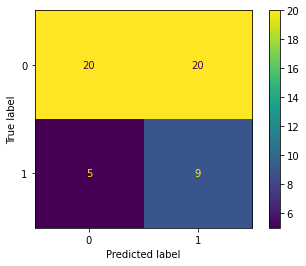

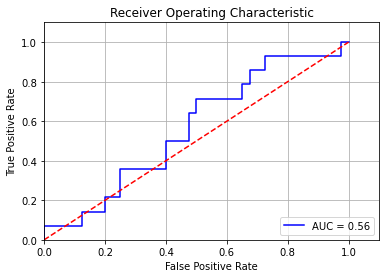

 F1 score on test set ----  0.5643675876234016
weighted roc auc on test set 0.5642857142857144
Specifity and sensitivity 0.5 0.6428571428571429


EMRVC(bias_used=False, init_alpha=3.7180249851279e-05)

In [14]:
Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,2)
train_RVC(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)

/tmp/ipykernel_68906/846717878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


number of training samples (array([0, 1]), array([111, 155]))
number of testing samples (array([0, 1]), array([41, 48]))
         subjs        age  sex   edu      fmem  diag
17   0a71a953d  71.743379    0  20.0 -0.468749     1
268  86f776f8c  68.877169    1  13.0  0.912979     1
221  71a96742a  73.086073    0  11.0 -0.517893     1
263  867a9f4da  77.046575    0  12.0  0.086599     1
205  66d373fff  79.032877    1  18.0  0.911091     0
..         ...        ...  ...   ...       ...   ...
317  9d346b71b  69.438584    1  18.0  0.430298     0
350  b15f3233e  59.833333    1  19.0  1.252592     1
131  4251bb8be  80.888128    1  10.0  0.451780     1
273  8796c61b4  73.866210    0  13.0  0.338037     1
393  c63ade830  63.796575    1  12.0  1.228777     0

[266 rows x 6 columns]


/home/kadajji/anaconda3/lib/python3.9/site-packages/sklearn_rvm/em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


Best Threshold=0.567215, G-Mean=0.497
(array([0, 1]), array([41, 48]))


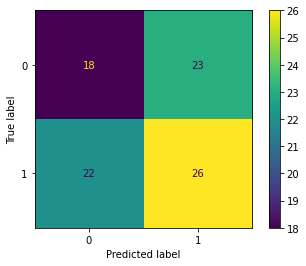

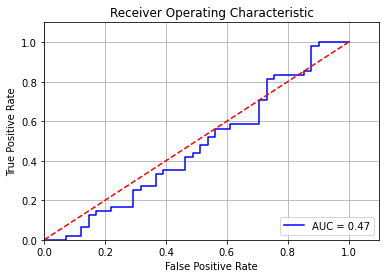

 F1 score on test set ----  0.4938672020798744
weighted roc auc on test set 0.4684959349593496
Specifity and sensitivity 0.43902439024390244 0.5416666666666666


EMRVC(bias_used=False, init_alpha=1.4027409558276873e-05)

In [15]:
Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,1)
train_RVC(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)

/tmp/ipykernel_68906/846717878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subjects_cn_mci['diag'] = subjects_cn_mci['diag'].map({0: 0, disease: 1})


number of training samples (array([0, 1]), array([115,  15]))
number of testing samples (array([0, 1]), array([37,  6]))
         subjs        age  sex   edu      fmem  diag
95   2dd25390a  70.987900    0  11.0 -1.727471     1
33   157dec7d5  69.847032    0  15.0  0.318927     0
276  88571e8a9  71.277397    0  16.0  0.019533     0
442  dff40316e  66.879909    1  14.0  0.585309     0
275  881977bc8  67.796575    1  12.0  0.622990     0
..         ...        ...  ...   ...       ...   ...
62   213b91d25  61.237900    1  18.0  1.089575     0
90   2c172a2a4  73.229680    0  13.0  0.387789     0
214  6e661b712  61.968721    1  13.0  0.703460     0
158  4db84ad1e  65.422146    0  14.0  0.310422     0
400  ca4672480  63.385388    1  16.0  1.630237     0

[130 rows x 6 columns]


/home/kadajji/anaconda3/lib/python3.9/site-packages/sklearn_rvm/em_rvm.py:675: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  warnings.warn("The default value of gamma will change "


Best Threshold=0.026547, G-Mean=0.808
(array([0, 1]), array([37,  6]))


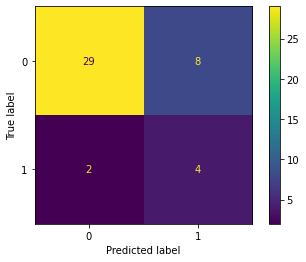

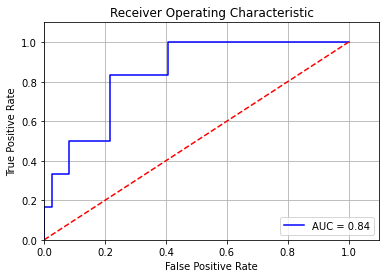

 F1 score on test set ----  0.7959416324669402
weighted roc auc on test set 0.8423423423423423
Specifity and sensitivity 0.7837837837837838 0.6666666666666666


EMRVC(bias_used=False, init_alpha=5.8271662490530857e-05)

In [16]:
Y_train_diag, Y_test_diag,X_train_diag, X_test_diag = create_train_test(subjects,con5,5)
train_RVC(Y_train_diag, Y_test_diag,X_train_diag, X_test_diag)